<a href="https://colab.research.google.com/github/firarru/SDpI/blob/main/Tubes_SDpI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Package**

In [1]:
# pip install optuna

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from io import StringIO
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# **Load Data**

In [3]:
input_file = "https://raw.githubusercontent.com/firarru/SDpI/refs/heads/main/Dataset/Dataset%20Tugas.csv"
output_file = 'cleaned_data.csv'

response = requests.get(input_file)
if response.status_code == 200:
    csv_content = response.text  # mengambil konten sebagai string

    # String IO untuk memanipulasi konten yang diambil
    infile = StringIO(csv_content)

    tes = 0
    with open(output_file, 'w') as outfile:
        buffer = ""  # menyimpan bagian pertama dari catatan yang terpotong (broken record)
        for line in infile: # untuk iterasi setiap baris infile
            tes += 1
            line = line.strip() # menghapus spasi kosong
            if buffer:  # jika buffer sudah berisi bagian pertama dari baris yang terpotong
                line = re.sub(r'(?<=\w), (?=\w)', ' ', line) # kode akan mengganti koma yang berada di antara kata-kata
                buffer += " " + line  # Menggabungkan baris

                # menghapus extra double quotes di LokasiToko
                buffer = re.sub(r'"', "", buffer)
                outfile.write(buffer + "\n")
                buffer = ""  # mengosongkan budder

            elif re.search(r'"".+"$', line):  # Detect lines ending with ""
                line = re.sub(r'(?<=\w), (?=\w)', ' ', line)
                buffer = line  # Start buffering (part 1)
            else:
                outfile.write(line + "\n")  # Write normal lines directly

    print(f"Processed {tes} lines. Cleaned data saved to {output_file}.")
else:
    print(f"Failed to fetch the file. HTTP status code: {response.status_code}")

Processed 200001 lines. Cleaned data saved to cleaned_data.csv.


StringIO digunakan untuk memanipulasi konten yang diambil sebagai string seolah olah adalah file yang berisi data baris dan kolom

In [4]:
df = pd.read_csv(output_file)
df.sample(10)

,IDKonsumen,IDProduk,Kuantitas,Harga,TglTransaksi,Pembayaran,LokasiToko,KategoriProduk,Diskon,JumlahTotal
35471,913903,D,8,95.738146,2/18/2024 12:56,Cash,5898 Taylor Row Myerschester OK 82601,Electronics,15.010987,650.935240
65450,677150,A,2,62.625309,4/7/2024 1:50,Debit Card,62243 Turner Park Suite 466 Lake Roberthaven M...,Electronics,18.644515,101.898247
10419,54578,A,1,20.146992,7/23/2023 16:21,Cash,24355 Debra Burgs Suite 457 Shaneborough OR 46584,Electronics,15.547359,17.014667
97473,464639,B,3,84.536489,5/18/2023 15:34,PayPal,34157 Gonzalez Park Suite 574 Christophermouth...,Electronics,18.662646,206.279230
71427,43968,D,8,80.885709,6/13/2023 7:21,Credit Card,769 Craig Stream East Meagan AS 14264,Home Decor,18.924878,524.625498
41591,873963,D,9,21.071563,12/26/2023 12:16,PayPal,USNV Butler FPO AE 23199,Clothing,7.899655,174.662841
67006,319747,B,2,20.533596,4/25/2024 22:11,Debit Card,553 Ann Mission Millerton WI 51500,Books,8.286867,37.664008
62171,350331,D,1,53.103284,9/1/2023 9:47,Debit Card,Unit 3858 Box 8385 DPO AA 47513,Books,0.455880,52.861197
25608,727138,B,1,35.666149,9/18/2023 3:11,Debit Card,59478 Jason Lodge Erinhaven HI 87708,Clothing,10.101860,32.063205
21676,864379,B,1,72.090604,3/13/2024 12:30,Debit Card,00763 Kenneth Pike Apt. 668 Jacksonberg FM 77688,Clothing,11.101999,64.087106


In [5]:
df.shape

(100000, 10)

# **Data Preprocessing**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IDKonsumen      100000 non-null  int64  
 1   IDProduk        100000 non-null  object 
 2   Kuantitas       100000 non-null  int64  
 3   Harga           100000 non-null  float64
 4   TglTransaksi    100000 non-null  object 
 5   Pembayaran      100000 non-null  object 
 6   LokasiToko      100000 non-null  object 
 7   KategoriProduk  100000 non-null  object 
 8   Diskon          100000 non-null  float64
 9   JumlahTotal     100000 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 7.6+ MB


In [7]:
df[['TglTransaksi', 'WaktuTransaksi']] = df['TglTransaksi'].str.split(' ', expand=True)

In [8]:
df[:1]

,IDKonsumen,IDProduk,Kuantitas,Harga,TglTransaksi,Pembayaran,LokasiToko,KategoriProduk,Diskon,JumlahTotal,WaktuTransaksi
0,109318,C,7,80.079844,12/26/2023,Cash,176 Andrew Cliffs Baileyfort HI 93354,Books,18.6771,455.862764,12:32


In [9]:
df['TglTransaksi'] = pd.to_datetime(df['TglTransaksi'])

In [10]:
df['WaktuTransaksi'] = pd.to_datetime(df['WaktuTransaksi'], format='%H:%M').dt.strftime('%H:%M')

In [11]:
df[:1]

,IDKonsumen,IDProduk,Kuantitas,Harga,TglTransaksi,Pembayaran,LokasiToko,KategoriProduk,Diskon,JumlahTotal,WaktuTransaksi
0,109318,C,7,80.079844,2023-12-26,Cash,176 Andrew Cliffs Baileyfort HI 93354,Books,18.6771,455.862764,12:32


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   IDKonsumen      100000 non-null  int64         
 1   IDProduk        100000 non-null  object        
 2   Kuantitas       100000 non-null  int64         
 3   Harga           100000 non-null  float64       
 4   TglTransaksi    100000 non-null  datetime64[ns]
 5   Pembayaran      100000 non-null  object        
 6   LokasiToko      100000 non-null  object        
 7   KategoriProduk  100000 non-null  object        
 8   Diskon          100000 non-null  float64       
 9   JumlahTotal     100000 non-null  float64       
 10  WaktuTransaksi  100000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 8.4+ MB


In [13]:
df = df[df['Diskon'] > 0]

In [14]:
df.shape

(100000, 11)

In [15]:
# df = df.sample(n=50000, random_state=42).reset_index(drop=True)

In [16]:
df.duplicated().sum()

0

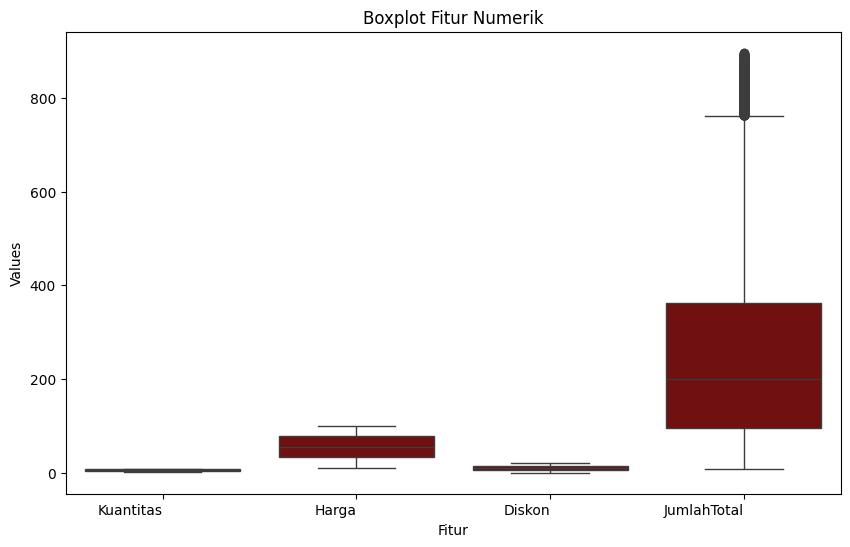

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Kuantitas', 'Harga', 'Diskon', 'JumlahTotal']], color='Maroon')
plt.title('Boxplot Fitur Numerik')
plt.xlabel('Fitur')
plt.ylabel('Values')
plt.xticks(rotation=0, ha='right')
plt.show()

In [18]:
def deteksi_outlier(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  return outliers

outliers = deteksi_outlier(df, 'JumlahTotal')
print('Nilai outlier terkecil : ', outliers['JumlahTotal'].min())
print('Nilai outlier terbesar  : ',outliers['JumlahTotal'].max())

Nilai outlier terkecil :  762.3996485
Nilai outlier terbesar  :  896.1412419


In [19]:
# df = df[df['JumlahTotal'] < 748 ]

In [20]:
cat_feature = df[['IDProduk', 'Pembayaran', 'KategoriProduk']]
num_feature = df[['Kuantitas', 'Harga', 'Diskon', 'JumlahTotal']]

# **EDA**

In [21]:
num_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
Kuantitas,100000.0,5.009290,2.579808,1.000000,3.000000,5.000000,7.000000,9.000000
Harga,100000.0,55.067344,25.971567,10.000430,32.549474,55.116789,77.456763,99.999284
Diskon,100000.0,10.020155,5.779534,0.000046,5.001013,10.030353,15.018367,19.999585
JumlahTotal,100000.0,248.334955,184.554792,8.274825,95.163418,200.368393,362.009980,896.141242


## Univariat

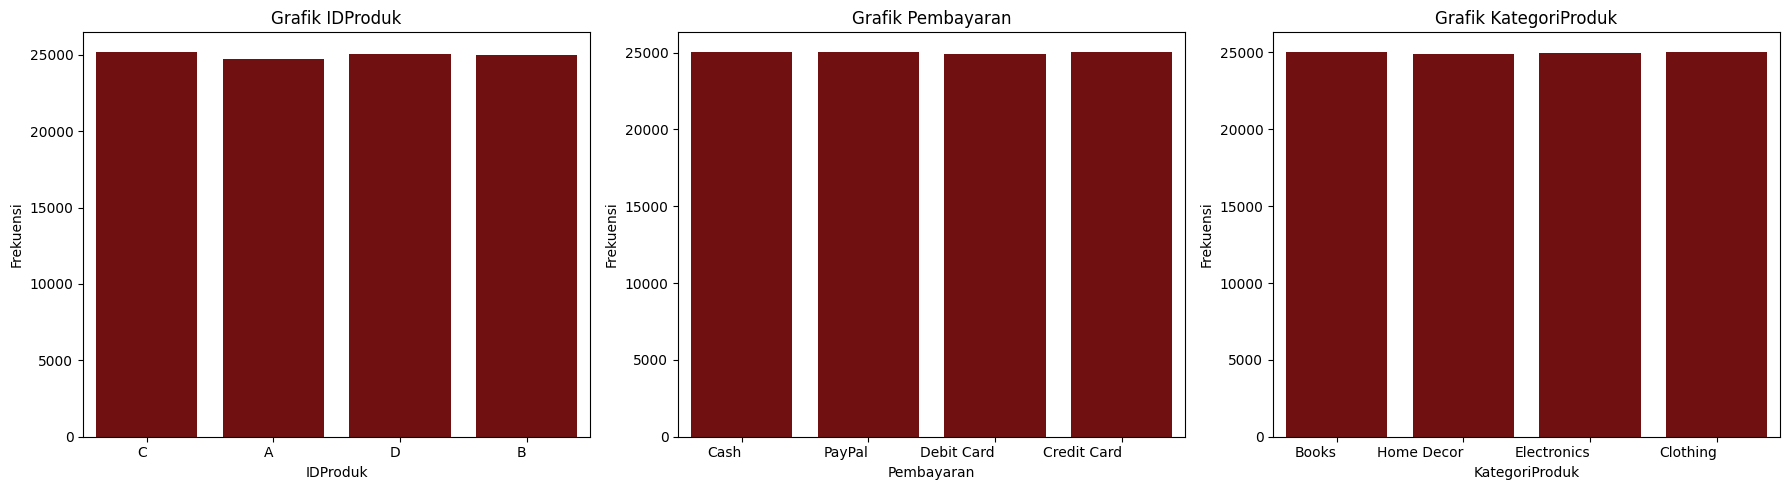

In [22]:
plt.figure(figsize=(18, 5))

for i, column in enumerate(cat_feature.columns, start=1):
    plt.subplot(1, 3, i)
    sns.countplot(x=column, data=cat_feature, color='maroon' )
    plt.title(f'Grafik {column}')
    plt.xlabel(column)
    plt.ylabel('Frekuensi')
    plt.xticks(rotation=0, ha='right')

plt.tight_layout()
plt.show()

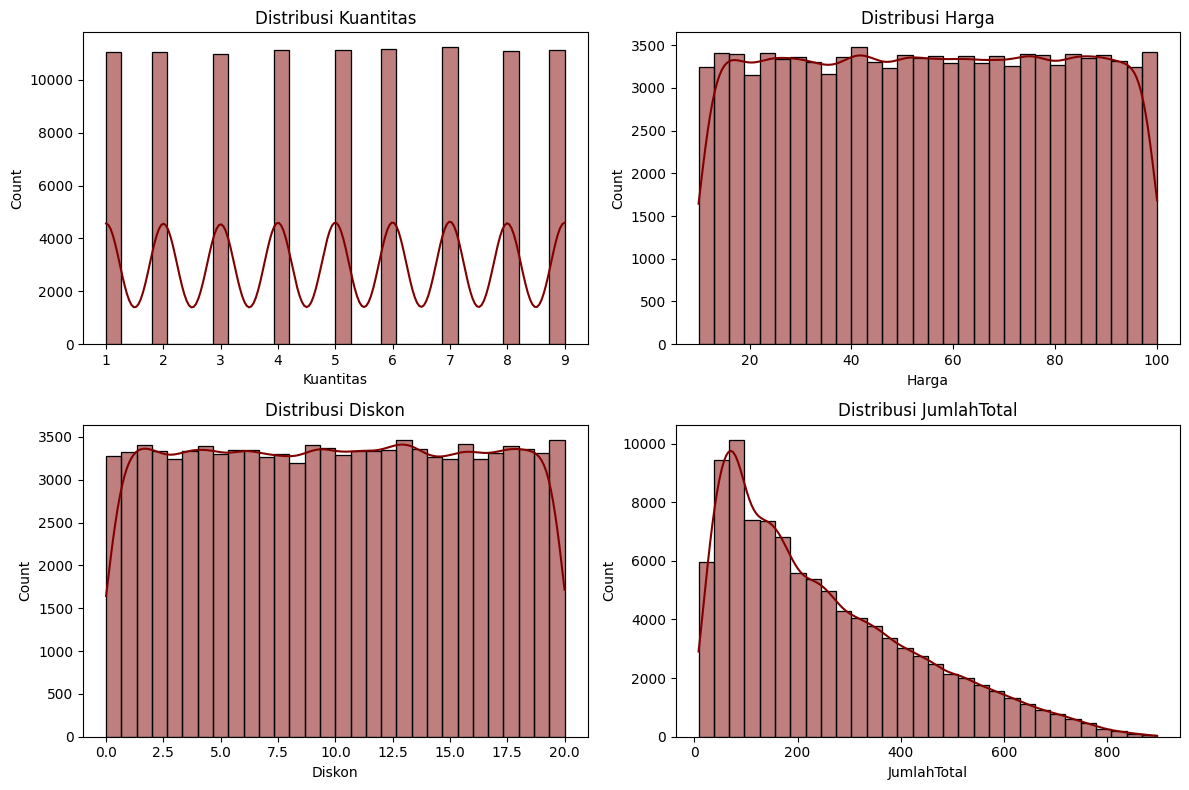

In [23]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(num_feature.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True, color='maroon', bins=30)
    plt.title(f'Distribusi {col}')

plt.tight_layout()
plt.show()

## Bivariat

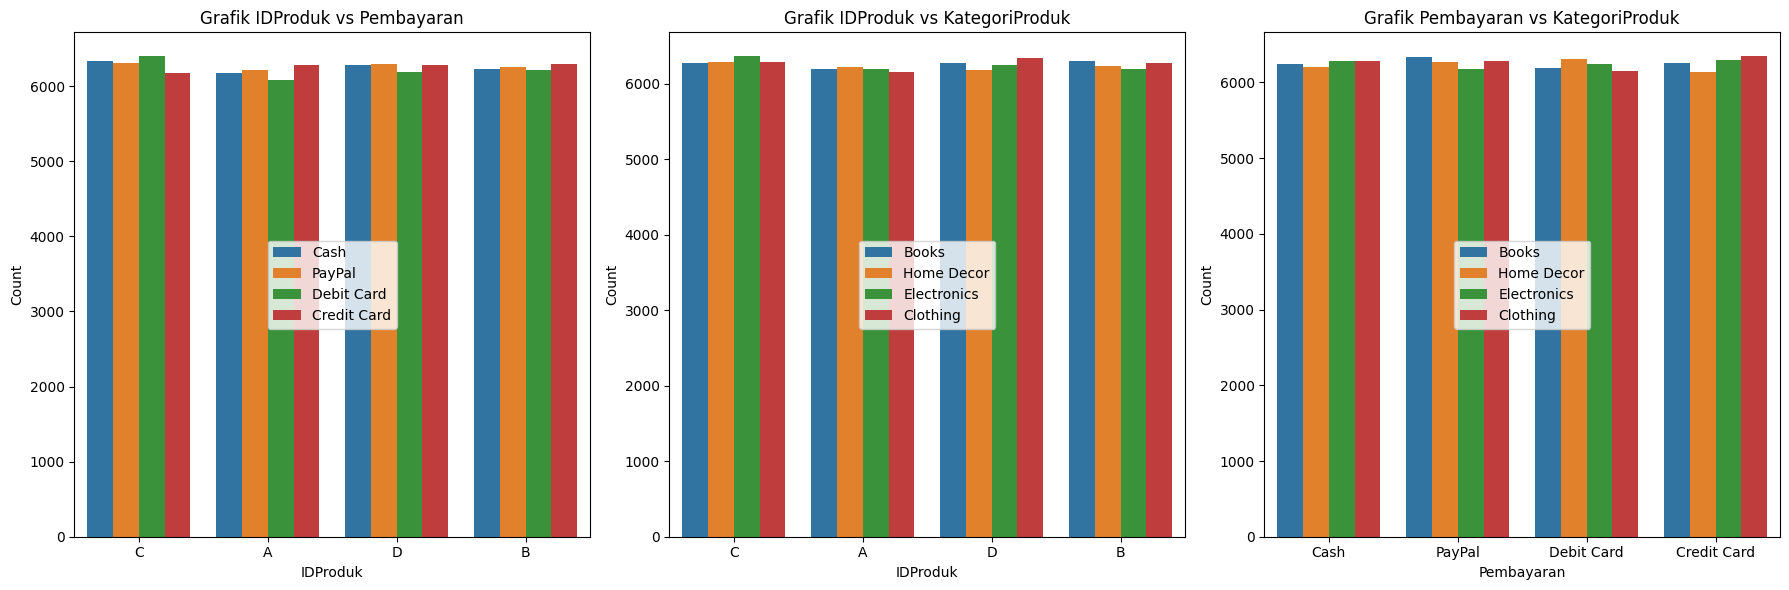

In [24]:
import itertools
combinations = list(itertools.combinations(cat_feature.columns, 2))

plt.figure(figsize=(18, 6))

for i, (col1, col2) in enumerate(combinations, start=1):
    plt.subplot(1, 3, i)
    sns.countplot(x=col1, hue=col2, data=cat_feature)
    plt.title(f'Grafik {col1} vs {col2}')
    plt.xlabel(col1)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(loc='center')

plt.tight_layout()
plt.show()

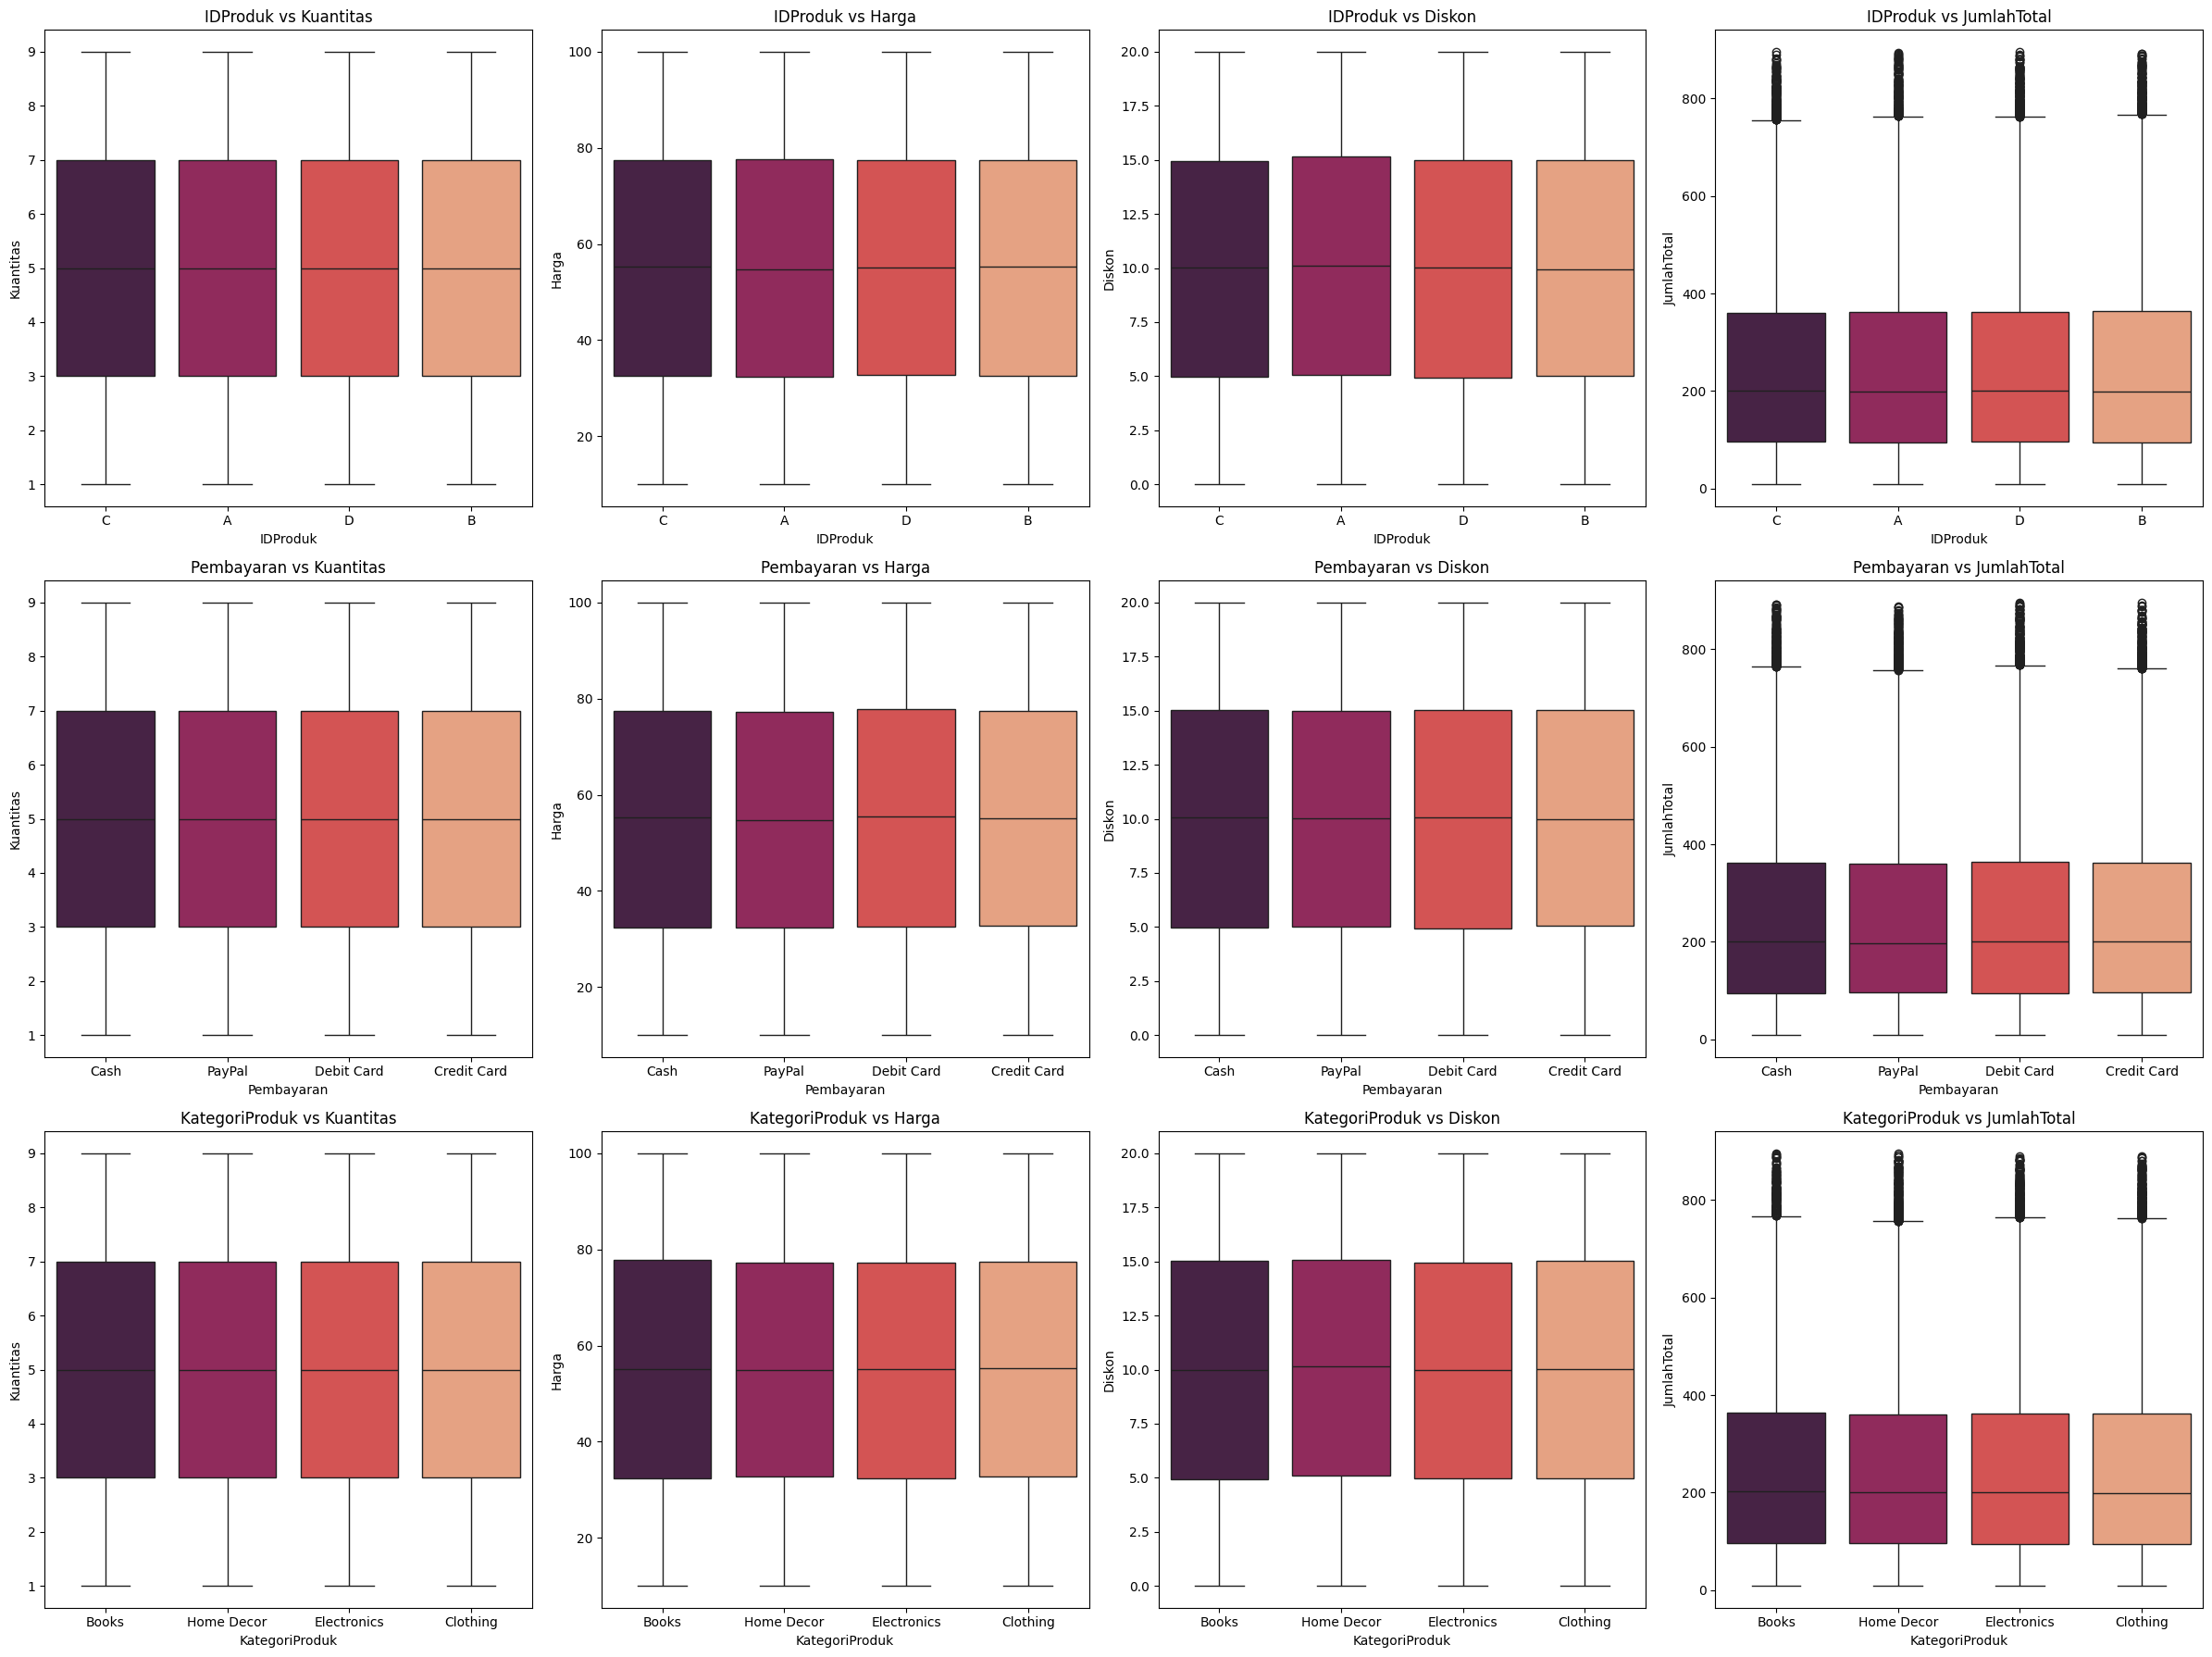

In [25]:
n_rows = len(cat_feature.columns)
n_cols = len(num_feature.columns)

plt.figure(figsize=(6 * n_cols, 6 * n_rows))

for i, col1 in enumerate(cat_feature.columns, start=1):
    for j, col2 in enumerate(num_feature.columns, start=1):
        plt.subplot(n_rows, n_cols, (i - 1) * n_cols + j)
        sns.boxplot(x=col1, y=col2, hue=col1, data=df, palette='rocket')
        plt.title(f'{col1} vs {col2}')
        plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

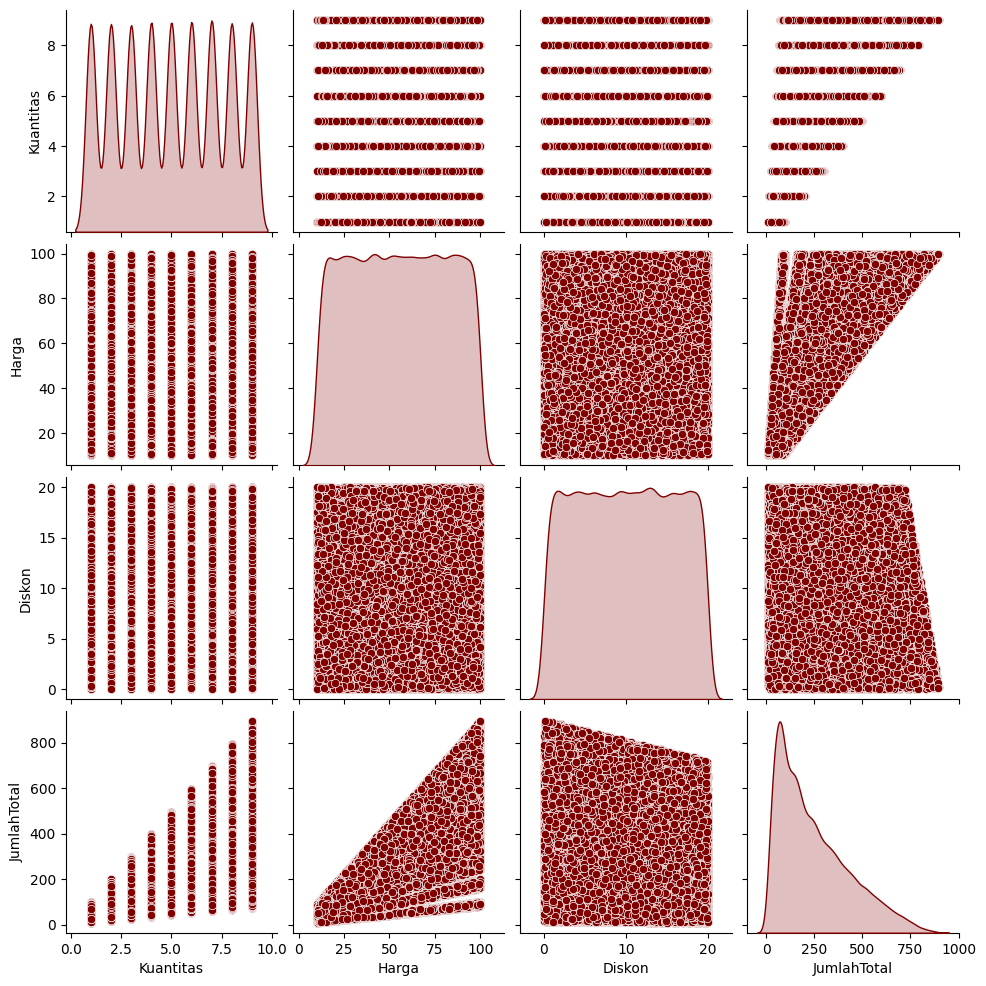

In [26]:
sns.pairplot(num_feature, diag_kind='kde', plot_kws={'color': 'maroon'}, diag_kws={'color': 'maroon'})
plt.show()

## Multivariat

<ipython-input-27-bb0cf69259cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pick[col] = LabelEncoder().fit_transform(df_pick[col])
<ipython-input-27-bb0cf69259cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pick[col] = LabelEncoder().fit_transform(df_pick[col])
<ipython-input-27-bb0cf69259cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

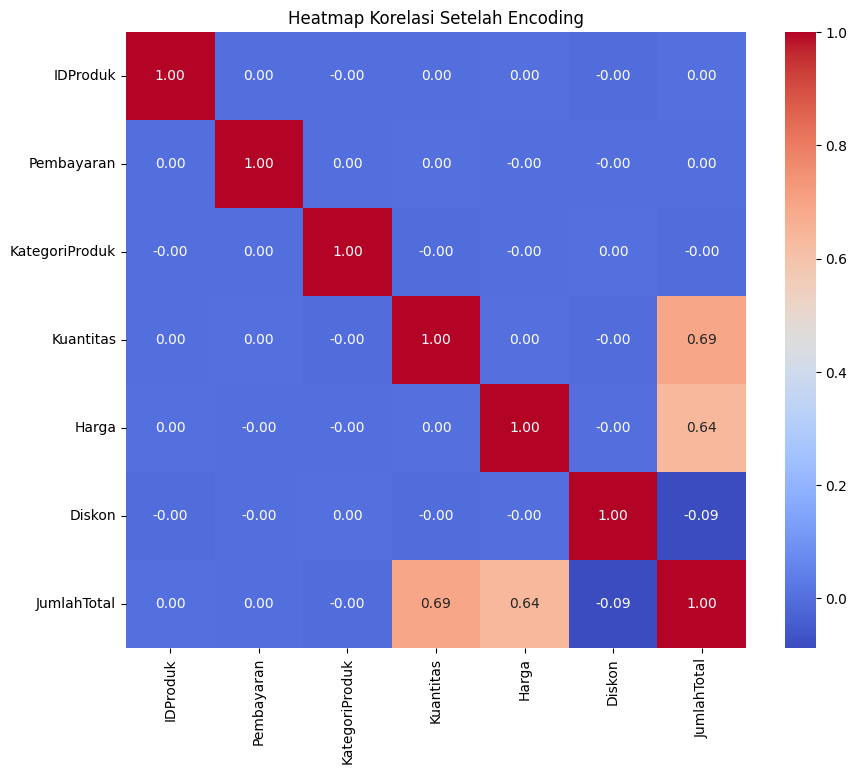

In [27]:
df_pick = df[['IDProduk', 'Pembayaran', 'KategoriProduk', 'Kuantitas', 'Harga', 'Diskon', 'JumlahTotal']]


for col in cat_feature:
    df_pick[col] = LabelEncoder().fit_transform(df_pick[col])

# Hitung korelasi untuk semua kolom
correlation_matrix = df_pick.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap Korelasi Setelah Encoding")
plt.show()

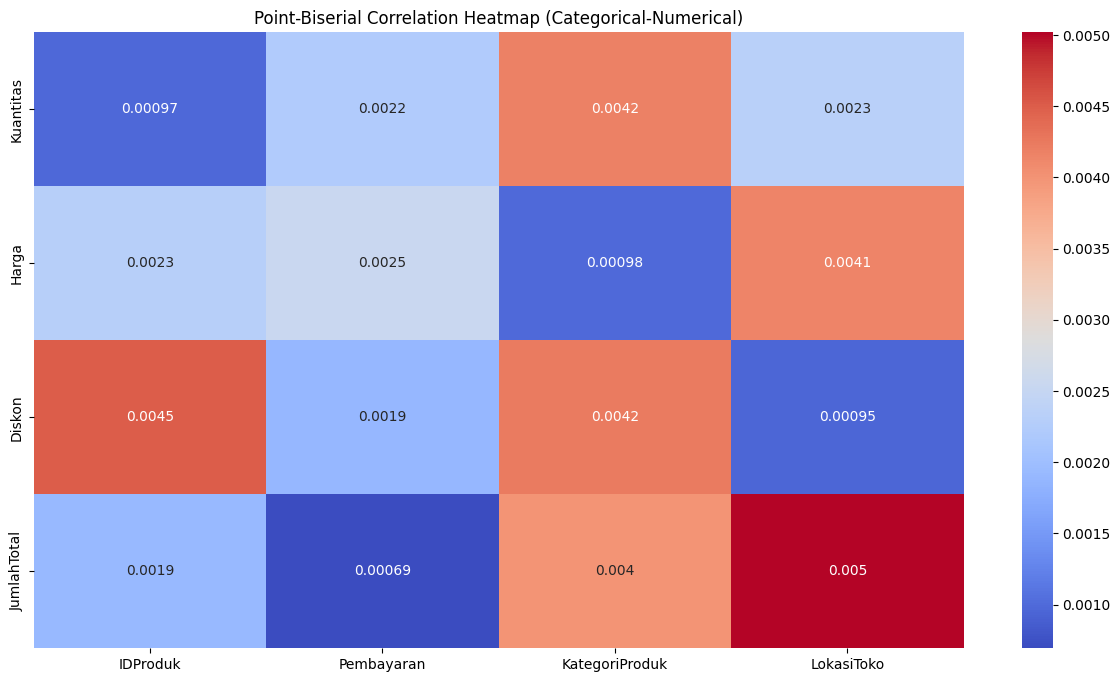

In [28]:
from scipy.stats import pointbiserialr

def point_biserial_matrix(df, categorical_cols, numerical_cols):
    # Get the column names as lists instead of DataFrames
    numerical_cols = numerical_cols.columns.tolist() # Change here to extract column names
    categorical_cols = categorical_cols.columns.tolist() # Change here to extract column names

    pb_matrix = pd.DataFrame(index=numerical_cols, columns=categorical_cols)

    # Lakukan encoding pada setiap kolom kategorikal secara independen
    for cat_col in categorical_cols:
        # Label encode data kategorikal
        encoded_cat = LabelEncoder().fit_transform(df[cat_col].astype(str))

        # Hitung korelasi point-biserial antara setiap kolom kategorikal dan numerik
        for num_col in numerical_cols:
            corr, _ = pointbiserialr(encoded_cat, df[num_col])
            pb_matrix.loc[num_col, cat_col] = abs(corr) #Nilai Absolut

    return pb_matrix.astype(float)

cat_fitur = df[['IDProduk', 'Pembayaran', 'KategoriProduk', 'LokasiToko']]
# Hitung korelasi antara variabel kategorikal dan numerikal
pb_matrix = point_biserial_matrix(df, cat_fitur, num_feature)

plt.figure(figsize=(15, 8))
sns.heatmap(pb_matrix, annot=True, cmap='coolwarm')
plt.title('Point-Biserial Correlation Heatmap (Categorical-Numerical)')
plt.show()

# **Transformasi**

In [29]:
df_encoded = df.copy()
cat_feature = df_encoded[['Pembayaran', 'KategoriProduk', 'IDProduk', 'LokasiToko']]

label_encoder = LabelEncoder()
for column in cat_feature.columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

df_encoded.sample(3)

,IDKonsumen,IDProduk,Kuantitas,Harga,TglTransaksi,Pembayaran,LokasiToko,KategoriProduk,Diskon,JumlahTotal,WaktuTransaksi
98438,891786,1,4,76.655952,2023-08-24,1,83577,3,17.064796,254.299083,01:09
53058,227784,3,5,87.903934,2024-02-18,1,88187,2,14.321237,376.575016,18:13
59035,983046,3,9,36.979379,2023-10-15,0,53638,2,13.148862,289.053102,01:39


In [30]:
df_encoded['Pembayaran'].unique()

array([0, 3, 2, 1])

In [31]:
scaler = StandardScaler()
fitur_scaled = scaler.fit_transform(num_feature)

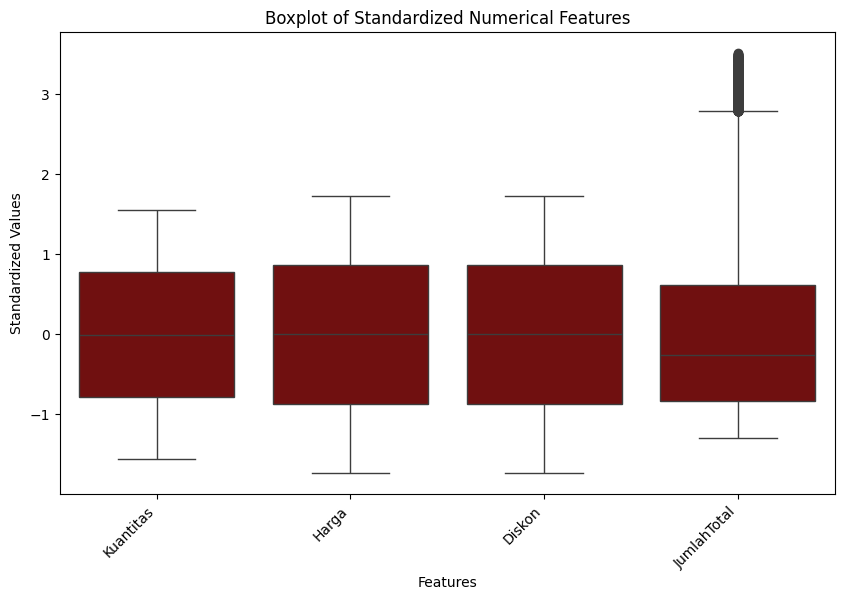

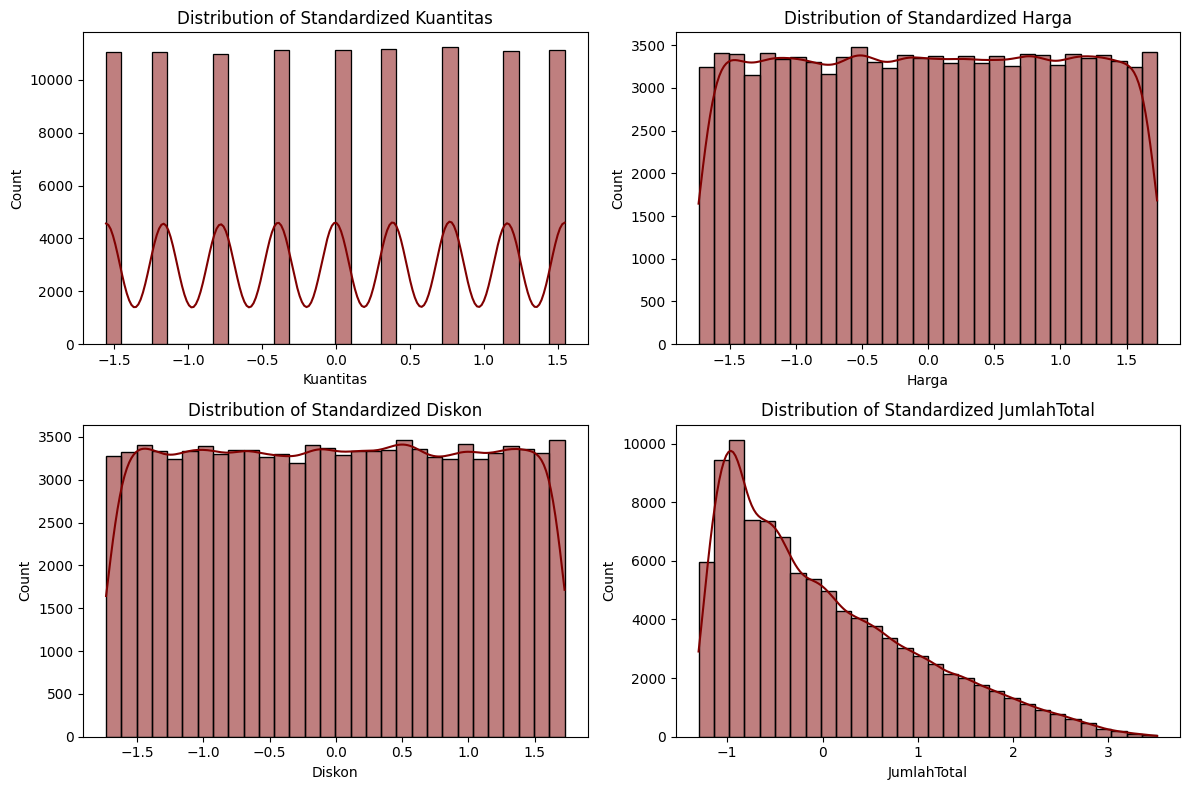

In [32]:
scaled_df = pd.DataFrame(fitur_scaled, columns=num_feature.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(data=scaled_df, color='maroon')
plt.title('Boxplot of Standardized Numerical Features')
plt.xlabel('Features')
plt.ylabel('Standardized Values')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(12, 8))
for i, col in enumerate(scaled_df.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(scaled_df[col], kde=True, color='maroon', bins=30)
    plt.title(f'Distribution of Standardized {col}')
    plt.tight_layout()
plt.show()

In [33]:
df_transform = df_encoded.copy()
df_transform['Kuantitas'] = scaled_df['Kuantitas']
df_transform['Harga'] = scaled_df['Harga']
df_transform['Diskon'] = scaled_df['Diskon']
df_transform['JumlahTotal'] = scaled_df['JumlahTotal']
df_transform[:1]

,IDKonsumen,IDProduk,Kuantitas,Harga,TglTransaksi,Pembayaran,LokasiToko,KategoriProduk,Diskon,JumlahTotal,WaktuTransaksi
0,109318,2,0.771654,0.963077,2023-12-26,0,15470,0,1.49787,1.124484,12:32


In [34]:
# df_transform.drop(columns=[,'LokasiToko', 'TglTransaksi', 'WaktuTransaksi'], inplace=True)

In [35]:
df_transform.drop(columns=['IDKonsumen','IDProduk', 'TglTransaksi', 'WaktuTransaksi'], inplace=True)

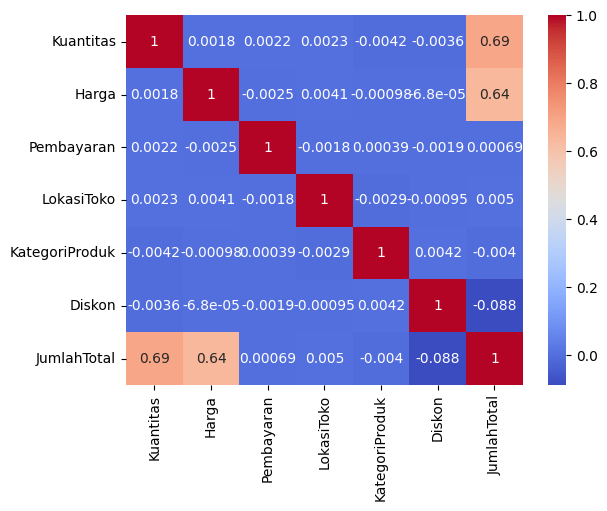

In [36]:
sns.heatmap(df_transform.corr(), annot=True, cmap='coolwarm')
plt.show()

Variabel target adalah kuantitas, variabel lain yang dipakai adalah diskon, harga

# **Split Data**

In [37]:
x = df_transform[['Diskon', 'Harga', 'Pembayaran']]
y = df_transform['Kuantitas']

In [38]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)

# **XGBoost Regressor**

In [39]:
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model.fit(x_train,y_train)
y_pred = xgb_model.predict(x_test)

In [40]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,y_pred)))

Mean Absolute Error : 0.8627082702172217


In [41]:
print(xgb_model.feature_importances_)

[0.36117056 0.3512051  0.2876243 ]


In [42]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 0.8627082702172217
MSE: 1.0005885066541973
RMSE:  1.0002942100473227


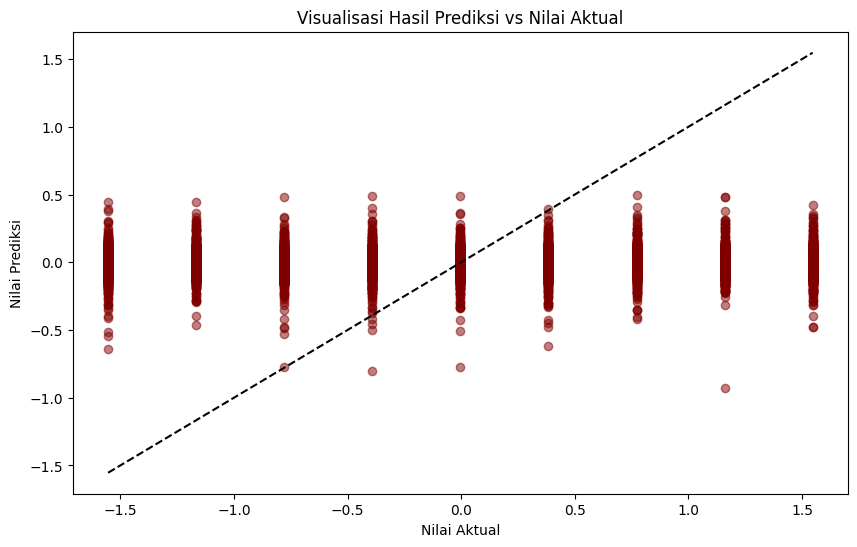

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='maroon')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Visualisasi Hasil Prediksi vs Nilai Aktual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--') # Garis ideal
plt.show()

Hyperparameter Tuning

In [44]:
# Fungsi untuk melakukan tuning dengan Optuna
def objective(trial):
    # Definisikan parameter
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 3.0),
        'random_state': 42
    }

    # Inisialisasi model
    model = XGBRegressor(objective='reg:squarederror', **param)

    # Training
    model.fit(x_train, y_train)

    # Prediksi
    y_pred = model.predict(x_test)

    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    return mse  # Tujuan adalah meminimalkan MSE

# Membuat studi Optuna
study = optuna.create_study(direction='minimize')  # Minimizing MSE
study.optimize(objective, n_trials=50, timeout=600)  # 50 trials atau maksimal 10 menit

[I 2024-12-26 19:23:31,721] A new study created in memory with name: no-name-5cb110f0-7893-4669-8e62-b52130881c6e
[I 2024-12-26 19:23:33,535] Trial 0 finished with value: 0.9994135174129477 and parameters: {'learning_rate': 0.058218793992742844, 'n_estimators': 134, 'max_depth': 4, 'subsample': 0.6929181176336616, 'colsample_bytree': 0.6635578432685697, 'gamma': 0.28100703034818814, 'reg_alpha': 0.6418667907979259, 'reg_lambda': 2.098622549877446}. Best is trial 0 with value: 0.9994135174129477.
[I 2024-12-26 19:23:35,738] Trial 1 finished with value: 1.0025167024360646 and parameters: {'learning_rate': 0.24478311506287773, 'n_estimators': 218, 'max_depth': 3, 'subsample': 0.6986339446432015, 'colsample_bytree': 0.6099534558956007, 'gamma': 0.35298294943589703, 'reg_alpha': 0.4257241327345167, 'reg_lambda': 1.8984632528313898}. Best is trial 0 with value: 0.9994135174129477.
[I 2024-12-26 19:23:36,506] Trial 2 finished with value: 0.9986044225459764 and parameters: {'learning_rate': 0.

In [45]:
# Hasil terbaik
print(f"Best Parameters: {study.best_params}")
print(f"Best MSE: {study.best_value}")

# Melatih model terbaik dengan parameter terbaik
best_params = study.best_params
best_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_model.fit(x_train, y_train)

y_pred_best = best_model.predict(x_test)

Best Parameters: {'learning_rate': 0.01113181395527995, 'n_estimators': 74, 'max_depth': 4, 'subsample': 0.9380081482119047, 'colsample_bytree': 0.999411466376354, 'gamma': 0.3102581451761945, 'reg_alpha': 0.9158828819680536, 'reg_lambda': 1.8699443720631321}
Best MSE: 0.9981220838188231


In [46]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_best))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_best))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred_best)))

MAE: 0.8596824211387972
MSE: 0.9981220838188231
RMSE:  0.9990606006738646


In [47]:
best_params = {
    'learning_rate': 0.01160461500075758,
    'n_estimators': 59,
    'max_depth': 5,
    'subsample': 0.7718288952859376,
    'colsample_bytree': 0.8690101561914465,
    'gamma': 0.09059446655033382,
    'reg_alpha': 0.7662226438445875,
    'reg_lambda': 1.654965816711759
}

best_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)

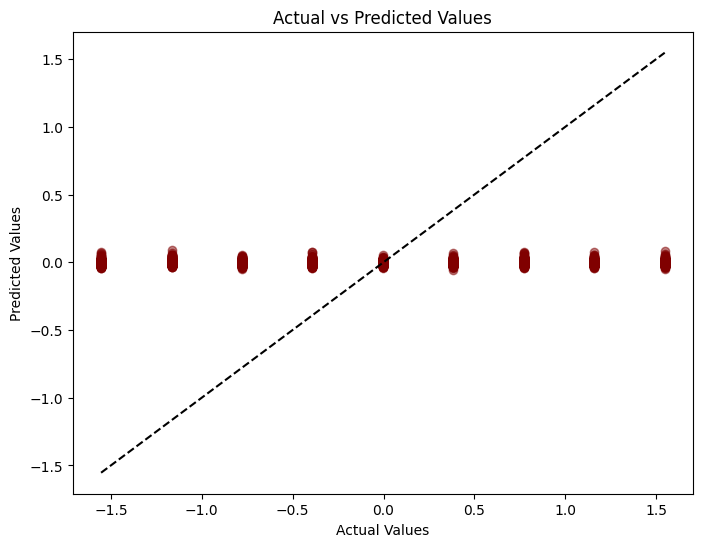

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='maroon')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title('Visualisasi Hasil Prediksi vs Nilai Aktual')
plt.show()

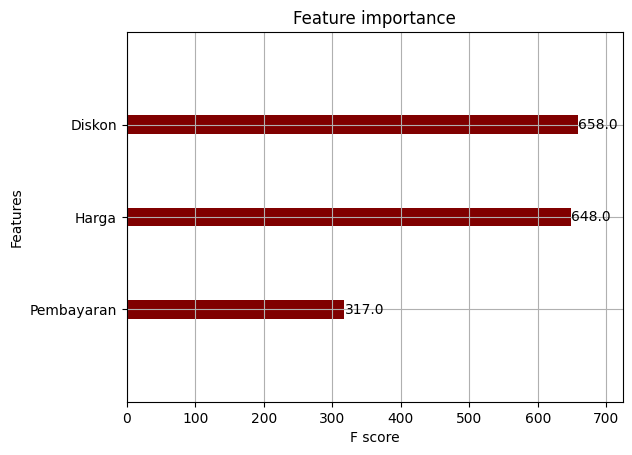

In [49]:
from xgboost import plot_importance
plot_importance(best_model, color='maroon')
plt.show()

# **Random Forest**

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=50)

rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=50)

In [51]:
y_pred = rf_model.predict(x_train)

In [52]:
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE: ',np.sqrt(mean_squared_error(y_train, y_pred)))

MAE: 0.3332586915216137
MSE: 0.15573439560131402
RMSE:  0.394631974884593


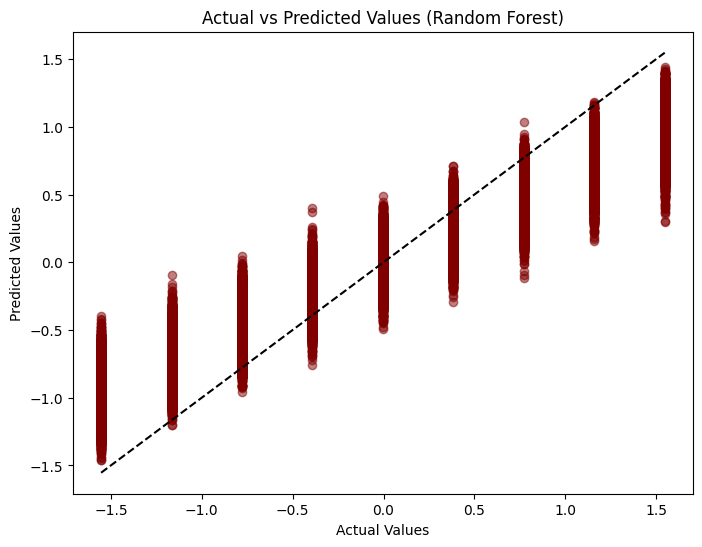

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred, alpha=0.5, color='maroon')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title('Visualisasi Hasil Prediksi vs Nilai Aktual')
plt.show()

Hyperparameter Tuning

In [54]:
# Fungsi untuk optimasi hyperparameter
def objective(trial):
    # Menentukan ruang pencarian untuk hyperparameter
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Jumlah estimators (pohon)
    max_depth = trial.suggest_int('max_depth', 3, 15)  # Kedalaman maksimum pohon
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimal sampel untuk split

    # Membuat model Random Forest dengan hyperparameter yang dipilih
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)

    # Menghitung MAE (Mean Absolute Error) sebagai metrik evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Membuat studi dan menjalankan pencarian
study = optuna.create_study(direction='minimize')  # Mencari untuk meminimalkan MAE
study.optimize(objective, n_trials=50)  # Menjalankan pencarian dengan 50 percobaan

[I 2024-12-26 19:25:43,886] A new study created in memory with name: no-name-3d6d77b6-146b-49b0-b392-80f2d97b3fd1
[I 2024-12-26 19:26:48,601] Trial 0 finished with value: 0.8618005228829211 and parameters: {'n_estimators': 190, 'max_depth': 13, 'min_samples_split': 8}. Best is trial 0 with value: 0.8618005228829211.
[I 2024-12-26 19:27:06,554] Trial 1 finished with value: 0.8597955513148539 and parameters: {'n_estimators': 180, 'max_depth': 4, 'min_samples_split': 2}. Best is trial 1 with value: 0.8597955513148539.
[I 2024-12-26 19:27:19,713] Trial 2 finished with value: 0.8615013719838287 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_split': 8}. Best is trial 1 with value: 0.8597955513148539.
[I 2024-12-26 19:27:30,891] Trial 3 finished with value: 0.8609892222629983 and parameters: {'n_estimators': 51, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 1 with value: 0.8597955513148539.
[I 2024-12-26 19:28:09,356] Trial 4 finished with value: 0.861543938960173

In [55]:
# Menampilkan hasil pencarian hyperparameter terbaik
print("Best Parameters:", study.best_params)
print("Best MAE:", study.best_value)

# Gunakan parameter terbaik untuk model akhir
best_params = study.best_params
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

best_model.fit(x_train, y_train)
y_pred_best = best_model.predict(x_test)

Best Parameters: {'n_estimators': 187, 'max_depth': 3, 'min_samples_split': 2}
Best MAE: 0.8596827315376457


In [56]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_best))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_best))
print('RMSE: ',np.sqrt(mean_squared_error(y_test, y_pred_best)))

MAE: 0.8596827315376457
MSE: 0.9981600614965916
RMSE:  0.9990796071868305


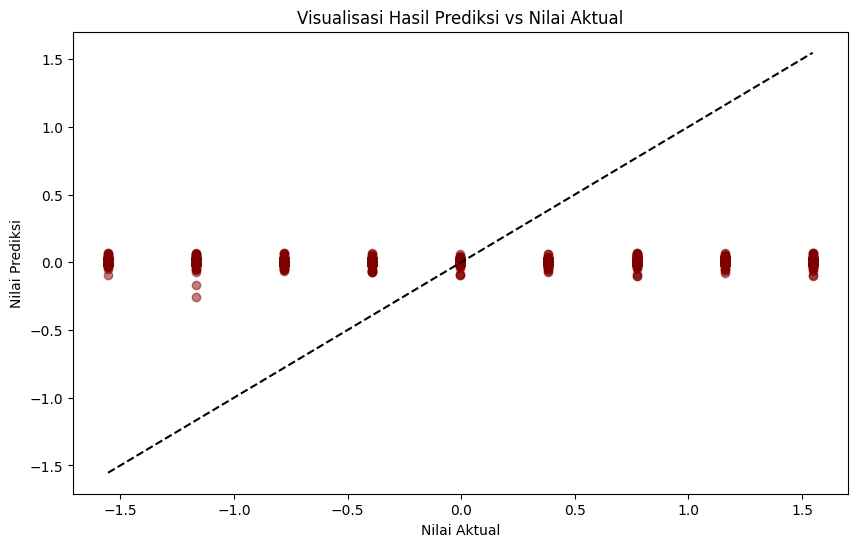

In [58]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color='maroon')
plt.xlabel("Nilai Aktual")
plt.ylabel("Nilai Prediksi")
plt.title("Visualisasi Hasil Prediksi vs Nilai Aktual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--') # Garis ideal
plt.show()